# Direct Pattern Evolution

![crossover](crossover.jpg)

In [241]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from direct import GA, Individual
import patterns
from plot import plot_fitnesses, plot_patterns, plot_best

# GA params
num_gens = 100
pop_size = 50
elitism = 1

# GA metaparams
num_repeats = 5
dimensions = [16, 32, 64]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


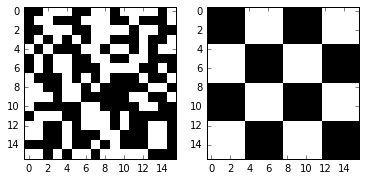

In [242]:
targets = [[patterns.random(d, d), patterns.checkerboard(d, d, 4)] for d in dimensions]
plot_patterns(*targets[0])

In [276]:
def run(Individual):
    fitnesses = np.zeros((len(dimensions), 2, num_repeats, num_gens))
    outputs = np.zeros((len(dimensions), 2, num_repeats), dtype=object)
    
    for di in range(len(dimensions)):
        mutation_rate = 1.0 / (dimensions[di]**2) # Average 1 mutation.
        for ti, target in enumerate(targets[di]):
            for ri in range(num_repeats):
                top = GA(pop_size, num_gens, elitism, target, Individual, mutation_rate)
                fitnesses[di, ti, ri] = [g.fitness for g in top]
                outputs[di, ti, ri] = top[-1].genome
            
    return fitnesses, outputs

# A 2D matrix genome with sub-section crossover

An individual contains a 2D genome that maps directly the phenotype. Crossover involves picking positions a and b in the matrix that define a subsection which is swiched from one to the other.

In [244]:
F, O = run(Individual)

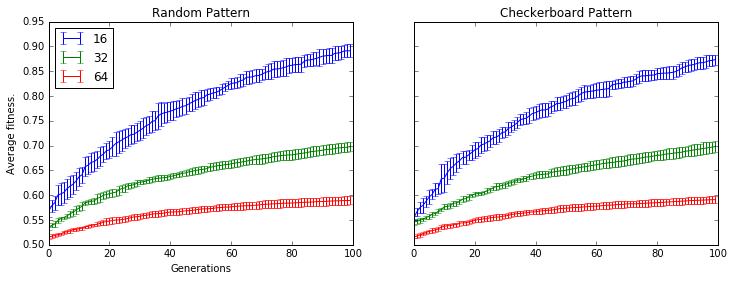

In [247]:
plot_fitnesses(F, dimensions, 'sub-matrix crossover')

Avg Best 16x16 Random Fitness: 0.891153963881
Avg Best 16x16 Grid Fitness: 0.8734375


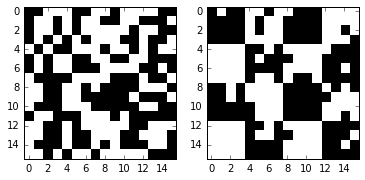

In [270]:
# Print best 16x16 targets
plot_best(F, O)

# A 2D Genome with sub-section crossover (no wrapping)

Let's validate wrapping subsections.

In [249]:
class IndividualNoWrap(Individual):
    def crossover(self, other):
        m, n = self.genome.shape
        i0, j0 = randint(0, m), randint(0, n)
        i1, j1 = randint(i0, m), randint(j0, n)
        child = copy.deepcopy(self)
        child.genome[i0:i1, j0:j1] = other.genome[i0:i1, j0:j1]
        return child

f_nw, o_nw = run(IndividualNoWrap)

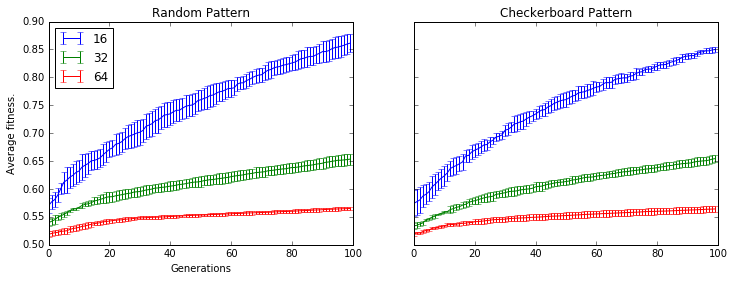

In [252]:
plot_fitnesses(f_nw, dimensions, 'sub-matrix crossover without wrapping')

Avg Best 16x16 Random Fitness: 0.86132231405
Avg Best 16x16 Grid Fitness: 0.85


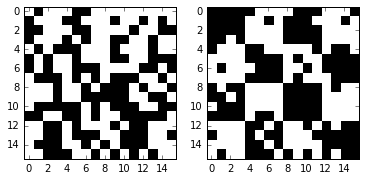

In [271]:
plot_best(f_nw, o_nw)

# A 2D matrix genome with different sub-section crossover

In [250]:
class IndividualRandomCross(Individual):
    def crossover(self, other):
        child = copy.deepcopy(self)
        m, n   = self.shape
        h, w   = randint(0, m), randint(0, n) # Size of crossover block
        ic, jc = randint(0, m), randint(0, n) # Child index offset
        io, jo = randint(0, m), randint(0, n) # Other index offset
        for i in range(h):
            for j in range(w):
                v = other.genome[(i+io)%m, (j+jo)%n]
                child.genome[(i+ic)%m, (j+jc)%n] = v
        return child

f_rand, o_rand = run(IndividualRandomCross)

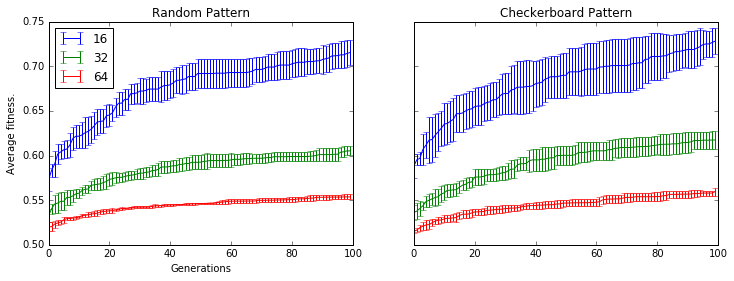

In [272]:
plot_fitnesses(f_rand, dimensions, 'random matrix crossover')

Avg Best 16x16 Random Fitness: 0.715322926232
Avg Best 16x16 Grid Fitness: 0.728125


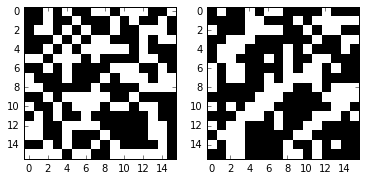

In [273]:
plot_best(f_rand, o_rand)

# A 1D matrix genome with two point crossover

In [251]:
class IndividualTwoPointCross(Individual):
    def crossover(self, other):
        child = copy.deepcopy(self)
        genome = child.genome.flatten()
        other = other.genome.flatten()
        i, j = randint(0, genome.size), randint(0, genome.size)
        if j < i:
            length = genome.size - j + i
        else:
            length = j - i
        i = randint(0, genome.size)
        inds = list(range(i, i+length))
        np.put(genome, inds, np.take(other, inds, mode='wrap'), mode='wrap')
        child.genome = genome.reshape(self.shape)
        return child

f_2p, o_2p = run(IndividualTwoPointCross)

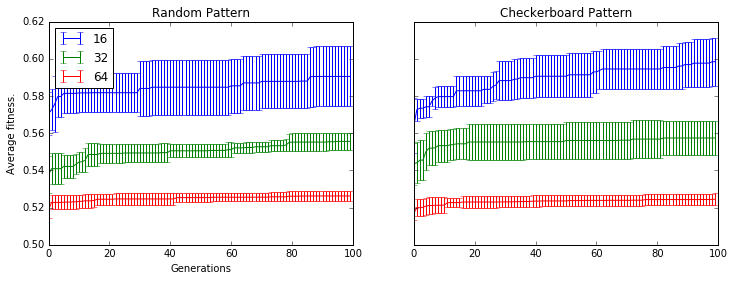

In [274]:
plot_fitnesses(f_2p, dimensions, 'linear genome, two point crossover')

Avg Best 16x16 Random Fitness: 0.590511172329
Avg Best 16x16 Grid Fitness: 0.5984375


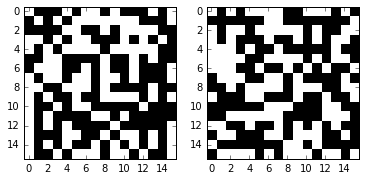

In [275]:
plot_best(f_2p, o_2p)